## DSAN 5650 HW2 Guide

In [1]:
%run jupyter_fixes.ipynb

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patchworklib as pw
import seaborn as sns

import pymc as pm
import arviz as az

<Figure size 100x100 with 0 Axes>

## [Part 4] A Non-Regression Example

### Why All the Different Models With Different Priors in the Beginning?

This part was intended to basically combine two key Bayesian Workflow "lessons" into one problem, but was maybe over-complicated because of this 😨. The two lessons are:

1.  The fact that the regressions you implemented in HW2A and HW2B are **far from the only models** that you can implement using PyMC, and then
2.  How you can **customize** your model, using **prior predictive checks**, to develop a parameterization that better captures the **range of possible data**, **before** the second step of then going and **estimating the specific values** of these parameters.

The importance of these prior predictive checks, that Part 4 is trying to drive home, is also captured in the following excerpts from [Gabry et al. (2019)](https://academic.oup.com/jrsssa/article/182/2/389/7070184):

> *If we specify proper priors for all parameters in the model, a Bayesian model yields a joint prior distribution on parameters and data, and hence a **prior marginal distribution** [a **prior predictive distribution**] for the data, i.e. Bayesian models with proper priors are generative models.*

which means that

> we can visualize **simulations from the prior marginal distribution** of the data to assess the consistency of the chosen priors with **domain knowledge**.

The implication here is that prior predictive model modeling is in fact **crucial to the scientific method!** However, rather than subjecting you to a full-on deep-dive into how different priors can represent different "states" of knowledge about scientific hypotheses, for now you can just focus on the goal of developing **weakly informative** priors, defined as follows (in the same paper):

> A prior leads to a **weakly informative** joint prior data-generating process if draws from the prior data-generating distribution $p(y)$ [the **prior predictive distribution**] could represent **any data set that could plausibly be observed**.

### A Simpler Prior-Focused Workflow

It may have been a bad idea to jump directly to **count** data here, since that's usually the third kind of model that you learn in e.g. a Statistical Learning course (like DSAN 5300)... So, here let's step back to the *second* kind of model that you usually learn: **logistic regression** for **binary** outcome data (the first kind of model you usually learn is basic linear regression for **continuous** outcome data, which is covered in HW2A and HW2B).

The goal of **weakly informative** priors would be, as mentioned above, to cover different **plausible datasets** that could be observed out in the world for the phenomenon you're trying to model.

So, here as a simple case let's try to develop a weakly informative prior for **NBA team outcomes**:

* The worst team in NBA history, by win percentage, was the 2011-2012 Charlotte Bobcats<sup>[1]</sup>, who won **7 games** out of a total of 66 that season (there are usually 82, but there was a labor dispute that year which cut the season short), for a win probability of **0.106**. Extrapolating to a standard 82-game season, this means they were on pace to win **9 games** (rounded to the nearest integer)
* The best team in NBA history, by win percentage, was the 2015-2016 Golden State Warriors, who won **73 games** out of a total of 82, for a win probability of **0.890**
* The Orlando Magic, this past season (2024-2025), achieved the most-average possible record, winning **41 games** out of a total of 82, for a win probability of exactly **0.500**.

So, if we were trying to model the different win probabilities for a given team across a given season, a **weakly informative** prior should at least be able to capture this range of possibilities, from 9 to 73 games<sup>[2]</sup>.

---

<small>

1.  For those who don't know this, Jeff for some reason really likes sports and is able to remember a bunch of random statistics from a bunch of random players/teams across different US professional sports. So... these are from memory, sorry if they're wrong.
2.  Don't worry -- as we'll see below, part of the whole modeling process is constructing a model that can satisfy **different people's opinions about what is "plausible"**. So, we'll get to the fact that it's possible for teams to be **worse** than the 2011-2012 Bobcats or **better** than the 2015-2016 Warriors!

</small>

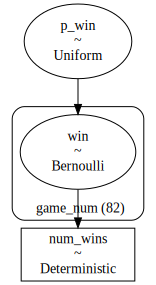

In [77]:
indices = {'game_num': list(range(1, 82+1))}
with pm.Model(coords=indices) as nba_model:
    p_win = pm.Uniform("p_win", 0, 1)
    win = pm.Bernoulli("win", p=p_win, dims="game_num")
    num_wins = pm.Deterministic("num_wins", pm.math.sum(win))
pm.model_to_graphviz(nba_model)

In [78]:
with nba_model:
    nba_prior_idata = pm.sample_prior_predictive(random_seed=5650)

Sampling: [p_win, win]


In [79]:
az.summary(nba_prior_idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
num_wins,42.246,24.658,4.000,81.000,1.105,0.495,470.0,436.0,NaN
win[1],0.480,0.500,0.000,1.000,0.022,0.001,507.0,500.0,NaN
win[2],0.534,0.499,0.000,1.000,0.022,0.002,503.0,500.0,NaN
win[3],0.518,0.500,0.000,1.000,0.021,0.001,545.0,500.0,NaN
win[4],0.524,0.500,0.000,1.000,0.023,0.001,471.0,471.0,NaN
...,...,...,...,...,...,...,...,...,...
win[79],0.528,0.500,0.000,1.000,0.023,0.001,474.0,474.0,NaN
win[80],0.530,0.500,0.000,1.000,0.022,0.001,500.0,500.0,NaN
win[81],0.498,0.500,0.000,1.000,0.022,0.000,537.0,500.0,NaN
win[82],0.564,0.496,0.000,1.000,0.023,0.003,461.0,461.0,NaN


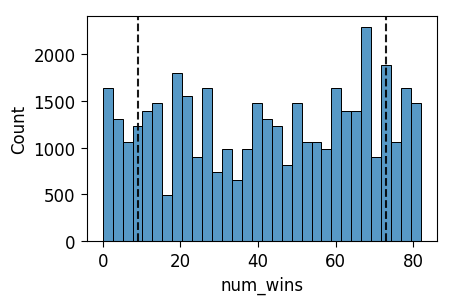

In [80]:
nba_prior_df = nba_prior_idata.prior.to_dataframe().reset_index().drop(columns="chain")
ax = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="num_wins", data=nba_prior_df, ax=ax,
);
ax.axvline(x = 9, ls='dashed', color='black', alpha=0.9);
ax.axvline(x = 73, ls='dashed', color='black', alpha=0.9);
ax.savefig()

And indeed, from this plot we can see that we have a **weakly informative** prior with respect to our above criteria: the prior predictive distribution assigns a positive probability mass to all values between 9 and 73.

In fact, now we can address the footnote above: here, even someone who believes that **any** number of wins between 0 and 82 inclusive is plausible would find this satisfactory as a **weakly informative** prior, since it actually assigns a positive probability mass to all values between 0 and 82.

This need not be the case, however -- meaning, there are priors which the "9 to 73 is plausible" person would call "weakly informative" while the "0 to 82 is plausible" person would not.

Here's an example, using the **Truncated** operator that PyMC provides, which allows us to do the following:

1.  Define a **Binomial** distribution to represent a number of games between 0 and 82, but then
2.  **Truncate** the pmf of the "true" 0-to-82 distribution down to a 9-to-73 distribution, by "chopping off" the values outside of $\{9, 10, \ldots, 73\}$ and re-normalizing the probability masses to sum to 1.

It's a bit silly, as you'll see from the visualization, and we're modeling the season as a whole rather than individual games like in the above model, but yeah it's here to show you an example prior which can violate the "weakly informative" criteria!

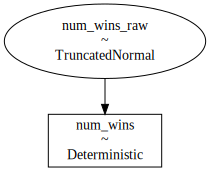

In [148]:
with pm.Model() as trunc_model:
    num_wins_raw = pm.TruncatedNormal("num_wins_raw", mu=41, sigma=20, lower=8.51, upper=73.49)
    num_wins = pm.Deterministic("num_wins", pm.math.round(num_wins_raw))
pm.model_to_graphviz(trunc_model)

In [153]:
with trunc_model:
    trunc_prior_idata = pm.sample_prior_predictive(draws=5000, random_seed=5650)

Sampling: [num_wins_raw]


In [154]:
az.summary(trunc_prior_idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
num_wins_raw,41.135,15.854,14.794,71.13,0.229,0.12,4808.0,4653.0,NaN
num_wins,41.134,15.852,12.000,68.00,0.229,0.12,4823.0,4600.0,NaN


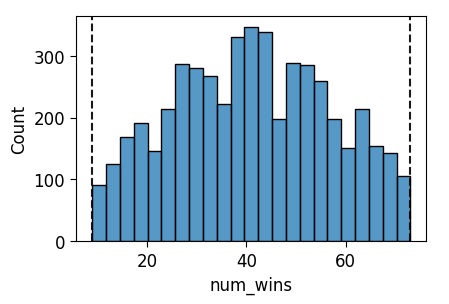

In [155]:
trunc_prior_df = trunc_prior_idata.prior.to_dataframe().reset_index().drop(columns="chain")
ax = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="num_wins", data=trunc_prior_df, ax=ax,
);
ax.axvline(x = 9, ls='dashed', color='black', alpha=0.9);
ax.axvline(x = 73, ls='dashed', color='black', alpha=0.9);
ax.savefig()

The visualization shows, if you look really closely, that we indeed have a weakly-informative prior relative to the first ("Only 9 to 73 is plausible") person's criteria, but it's not weakly-informative relative to the second ("0 to 82 is plausible") person's. We could also directly verify this by converting the data from the 10,000 draws into a proper probability distribution and checking that it in fact assigns positive probability mass to each value from 9 to 73:

In [157]:
trunc_prior_df['num_wins'] = trunc_prior_df['num_wins'].astype(int)
win_counts_df = trunc_prior_df['num_wins'].value_counts().to_frame().reset_index().sort_values(by='num_wins')
win_counts_df['prob'] = win_counts_df['count'] / win_counts_df['count'].sum()
win_counts_df

,num_wins,count,prob
64,9,24,0.0048
60,10,36,0.0072
62,11,31,0.0062
55,12,44,0.0088
59,13,38,0.0076
...,...,...,...
51,69,51,0.0102
57,70,42,0.0084
56,71,43,0.0086
61,72,33,0.0066


And we see, indeed, a low-but-positive probability mass on each number of wins from 9 to 73!

## [Part 5] Firing Squad

It's a bit hard to come up with starter code for this question but, let's try! Note how the Firing Squad example boils down to just a bunch of **dyadic** (two-node) relationships like:

* If the Court Orders come in, then the Captain announces the order
* If the Captain announces the order, Soldier $A$ shoots
* If the Captain announces the order, Soldier $B$ shoots
* If Soldier $A$ shoots, the Prisoner dies
* If Soldier $B$ shoots, the Prisoner dies

So, maybe the starter code can just be one "link" in this chain of causality. Let's model a dog named Selena who has been trained to **dance** ($D$) when the command [**"¡Baila conmigo!"**](https://translate.google.com/?sl=es&tl=en&text=%22%C2%A1Baila%20conmigo!%22&op=translate) ($BC$) is spoken. We'll model a single *hangout session* with the dog as follows:

* In a given hangout session, the dog trainer issues the **"¡Baila conmigo!"** ($BC$) command with probability $0.8$
* If the command is issued, Selena **dances** ($D$) with 100% certainty. Otherwise, she doesn't dance.

### Working Through a Solution

Let's start by interpreting the facts in the problem as explicit probabilities, to make sure we're on the same page:

* In a given hangout session, the dog trainer issues the **"¡Baila conmigo!"** ($BC$) command with probability $0.8$: $\Pr(BC) = 0.8$
* If the command is issued, Selena **dances** ($D$) with 100% certainty: $\Pr(D \mid BC) = 1.0$

Let's say we start by just trying to model the command $BC$ as happening with probability $0.8$, and the dance $D$ happening with probability $1$, without linking the two together. We'd get something like the following:

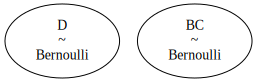

In [21]:
with pm.Model() as bad_dance_model:
    BC = pm.Bernoulli("BC", p=0.8)
    D = pm.Bernoulli("D", p=1.0)
pm.model_to_graphviz(bad_dance_model)

And by displaying the PGM like this, we can see that something has gone wrong with our modeling, since the command $BC$ is supposed to have an effect on dancing $D$: there's supposed to be an arrow from $BC$ to $D$!

So, this points us towards the fact that the parameter `p`, the probability of the `pm.Bernoulli()` Random Variable `D`, should depend on `BC`. In this case, we can use `pm.math.switch()` as basically an `if` statement which determines the final value of `p`:

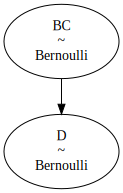

In [22]:
with pm.Model() as dance_model:
    BC = pm.Bernoulli("BC", p=0.8)
    D = pm.Bernoulli("D", p=pm.math.switch(BC, 1.0, 0.0))
pm.model_to_graphviz(dance_model)

And now the PGM looks as expected.

### Probabilities Without $\textsf{do}()$

Off rip, let's "extract" some general probabilistic facts about this stochastic system we've now set up, before we apply $\textsf{do}()$ or observe data or anything like that.

To achieve this, we use the first of **three different ways** you can derive information from a `pm.Model()` object: PyMC's `sample_prior_predictive()` function<sup>[1]</sup>. The way I think of this function is that it tells us what we can say about the different variables without having any additional information besides the model itself: any information, that is, besides the probability distributions of the RVs and how they're linked together.

Sampling from the prior distribution looks as follows:

---

<small>

1.  The names of the functions in PyMC are extremely confusing imo (though they do update them all the time given user feedback!): the two types of **posterior** distributions have separate sampling functions, `sample()` for the posterior and `sample_posterior_predictive()` for the posterior predictive distribution. However, for reasons I don't entirely understand, we use `sample_prior_predictive()` to obtain **both** the prior **and** prior predictive distributions.

</small>

In [23]:
with dance_model:
    dance_prior_idata = pm.sample_prior_predictive(random_seed=5650)

Sampling: [BC, D]


Printing out the information in `dance_prior_idata` on its own isn't that helpful, unless you already know how the [`xarray` library](https://docs.xarray.dev/en/stable/) works (which is good to know!), but there are two other ways to display the results that are a bit more helpful.

First, there is a [library called `arviz`](https://www.arviz.org/en/latest/) -- which actually used to be part of PyMC until it was split off as an independent Bayesian inference visualization library -- that you can use to display **summary statistics** of the sampling:

In [24]:
az.summary(dance_prior_idata.prior)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,0.762,0.426,0.0,1.0,0.021,0.013,412.0,412.0,NaN
BC,0.762,0.426,0.0,1.0,0.021,0.013,412.0,412.0,NaN


Second, to use the full results of the sampling, you can just convert the `idata` object into a Pandas `DataFrame` by using the `.to_dataframe()` function:

In [25]:
dance_prior_df = dance_prior_idata.prior.to_dataframe()
dance_prior_df

D  BC
chain draw       
0     0     0   0
      1     1   1
      2     1   1
      3     0   0
      4     0   0
...        ..  ..
      495   0   0
      496   1   1
      497   1   1
      498   1   1
      499   1   1

[500 rows x 2 columns]

If we use this on its own, you'll notice that it produces a fancy `DataFrame` with a dual index: first indexed by `chain` and then by `draw`. This can be helpful in general, but to me it makes it complicated (since for example `chain` is useless here while `draw` can't be treated like a normal column since it's an index), so I like to use `.reset_index()` to transform these from indices into regular columns, and then I usually drop `chain` (this only becomes useful when you start doing fancy Markov Chain Monte Carlo estimation where you use multiple chains so that you can basically throw away non-convergent estimations):

In [26]:
dance_prior_df = dance_prior_idata.prior.to_dataframe().reset_index().drop(columns="chain")
dance_prior_df

,draw,D,BC
0,0,0,0
1,1,1,1
2,2,1,1
3,3,0,0
4,4,0,0
...,...,...,...
495,495,0,0
496,496,1,1
497,497,1,1
498,498,1,1


And now that we have the samples in this form, we can plot them using e.g. `seaborn` like any other data in a Pandas `DataFrame`! As a "wrapper" around `seaborn` that makes it easier to arrange multiple plots in a grid, I use a library called `patchworklib`, which is what the `pw.Brick()` and the `ax.savefig()` lines are for here. For example, I can create plots of the distributions for both $BC$ and $D$ here and then place them side-by-side using `|`:

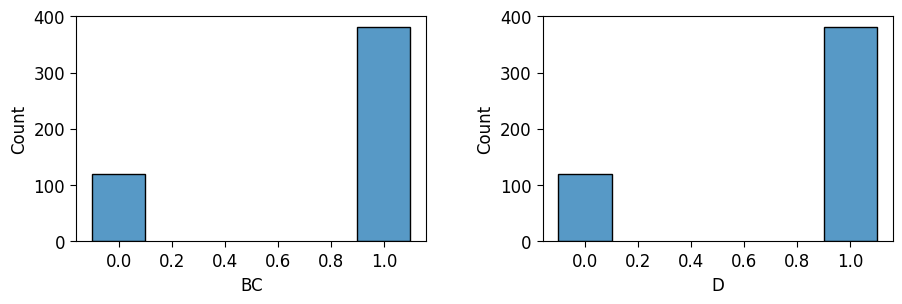

In [35]:
ax_bc = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="BC", data=dance_prior_df, ax=ax_bc, discrete=True, shrink=0.2
);
ax_d = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="D", data=dance_prior_df, ax=ax_d, discrete=True, shrink=0.2
);
ax_prior = ax_bc | ax_d;
ax_prior.savefig()

### Applying the $\textsf{do}()$ Operator

The above plots represent properties of the *stochastic system* we've defined, at the first -- **associational** -- level of the Ladder of Causal Inference. But, as we've discussed ad nauseam in class, to learn about the second -- **causal** -- level of this ladder, we'd like to see what happens when we **intervene** to **force** our model to represent the world where the command $BC$ is issued: how does this affect the "downstream" dance variable $D$?

By intervening to force $BC \leftarrow 0$, and then separately to force $BC \leftarrow 1$, and looking at the resulting values of $D$, we can infer precisely the **causal impact** of $BC$ on $D$, rather than just the co-occurrence-based conditional probability $\Pr(D \mid BC)$.

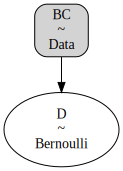

In [36]:
from pymc.model.transform.conditioning import do
do_BC1_model = do(dance_model, {'BC': 1})
pm.model_to_graphviz(do_BC1_model)

In [37]:
with do_BC1_model:
    BC1_idata = pm.sample_prior_predictive(random_seed=5650)

Sampling: [D]


In [40]:
BC1_idata_df = BC1_idata.prior.to_dataframe()
BC1_idata_df

D
chain draw   
0     0     1
      1     1
      2     1
      3     1
      4     1
...        ..
      495   1
      496   1
      497   1
      498   1
      499   1

[500 rows x 1 columns]

In [41]:
BC1_idata_df['D'].mean()

1.0

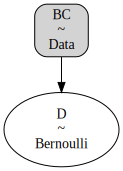

In [42]:
from pymc.model.transform.conditioning import do
do_BC0_model = do(dance_model, {'BC': 0})
pm.model_to_graphviz(do_BC0_model)

In [43]:
with do_BC0_model:
    BC0_idata = pm.sample_prior_predictive(random_seed=5650)
BC0_idata_df = BC0_idata.prior.to_dataframe()
BC0_idata_df

Sampling: [D]


D
chain draw   
0     0     0
      1     0
      2     0
      3     0
      4     0
...        ..
      495   0
      496   0
      497   0
      498   0
      499   0

[500 rows x 1 columns]

In [44]:
BC0_idata_df['D'].mean()

0.0

And so we get our causal effect:

$$
\mathbb{E}[D \mid \textsf{do}(BC \leftarrow 1)] - \mathbb{E}[D \mid \textsf{do}(BC \leftarrow 0)] = 1 - 0 = 1
$$

### $\textsf{do}()$ vs. Conditional Probability in this Model

Now, what would the **conditional probability** $\Pr(D \mid BC)$ give us here? Let's check using the `dance_prior_df` `DataFrame` we created earlier, but just subsetting it to check co-occurrences rather than using the fancy `do()` function in PyMC:

In [46]:
BC1_df = dance_prior_df[dance_prior_df['BC'] == 1].copy()
BC1_df['D'].mean()

1.0

In [48]:
BC0_df = dance_prior_df[dance_prior_df['BC'] == 0].copy()
BC0_df['D'].mean()

0.0

And so we have, in this case, that

$$
\mathbb{E}[D \mid BC = 1] - \mathbb{E}[D \mid BC = 0] = 1 - 0 = 1,
$$

meaning that the causal effect is **equal to** the conditional effect:

$$
\mathbb{E}[D \mid \textsf{do}(BC \leftarrow 1)] - \mathbb{E}[D \mid \textsf{do}(BC \leftarrow 0)] = \mathbb{E}[D \mid BC = 1] - \mathbb{E}[D \mid BC = 0]
$$

Why did we get this result in this case? If we tried to generalize from this (which lots of early scientists do), we might think it means that $\textsf{do}()$ is unnecessary overkill -- it looks like we can just use the conditional operator $|$... But, in fact, the above equality only holds because **the model was so simple** that there were **no backdoor paths** which could **bias** the conditional probabilities **away from** the direct causal effect.

### The Relation to Backdoor Paths

The Firing Squad example, however, is **not so simple**: on top of the direct path $A \rightarrow D$, there is a **backdoor path** $A \leftarrow C \rightarrow B \rightarrow D$, which has exactly the effect of making the $\textsf{do}()$-based difference

$$
\mathbb{E}[D = 1 \mid \textsf{do}(A \leftarrow 1)] - \mathbb{E}[D = 1 \mid \textsf{do}(A \leftarrow 0)]
$$

**not equal to** the conditional difference

$$
\mathbb{E}[D = 1 \mid A = 1] - \mathbb{E}[D = 1 \mid A = 0].
$$

If we had enough data on $D$ with respect to the behavior of $A$ (for example, data on $A$ shooting and not-shooting in different Firing Squads) and $C$ (for example, cases where $C$ decided not to follow the court orders, and refused to order the shooting), then we know from class that we could in fact **infer the causal $\textsf{do}()$-based effect from this observational data** by **closing the backdoor path**:

Since $C$ is a **fork** in the triple $A \leftarrow C \rightarrow B$, the first triple in the backdoor path here, we know that we could compute $\mathbb{E}[D = 1 \mid A = 1] - \mathbb{E}[D = 1 \mid A = 0]$ separately for the two different values of $C$ ($C = 1$ and $C = 0$), and if our causal model was indeed the truth about the world then we would successfully obtain the $\textsf{do}()$-based effect **without actually having to intervene in the system**! 